In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection')

In [ ]:
import numpy as np
import seaborn as sns
import codecs
from tqdm import tqdm
from keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of unique words:  123659


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of news: 16646
Median length of the news: 317


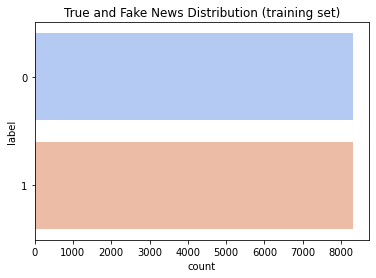

Number of True News in the Training Set: 8323
Number of Fake News in the Training Set: 8323


In [ ]:
from data_preprocessing_fulldataset import unique_words, padded_train, padded_test, Y_train, Y_test, median, word_index

# Best Model

Pre-trained Word Embedding with GloVe

In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/glove.42B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


1917495it [03:04, 10420.85it/s]

found 1917495 word vectors


In [ ]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(unique_words, len(word_index))+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 29840


In [ ]:
best_model= Sequential()

best_model.add(Embedding(nb_words, output_dim = 300, input_length=median, weights=[embedding_matrix]))

best_model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.3))

best_model.add(Conv1D(filters=64, kernel_size=3, activation = "relu"))    
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.3)) 

best_model.add(Conv1D(filters=64, kernel_size=3, activation = "relu"))    
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.3)) 
                                  
best_model.add(Bidirectional(LSTM(64, return_sequences=True)))
best_model.add(GlobalMaxPool1D())
best_model.add(Dropout(0.3))

best_model.add(Dense(128, activation="relu"))
best_model.add(Dense(1, activation="sigmoid"))

best_model.compile(optimizer=Adam(lr=0.001, clipnorm=1), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 317, 300)          35958600  
                                                                 
 conv1d (Conv1D)             (None, 315, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 157, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 157, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 155, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 77, 64)           0         
 1D)                                                    

# Best Model Retraining on full dataset

In [ ]:
# Train loss achieved with Model Selection
train_thold = 0.0117

In [ ]:
# Stopping criterion (Retrain until the loss is above the threshold)

class SOMT(Callback):

    def __init__(self, model,  train_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        
    def on_epoch_end(self,epoch, logs={}): 
        tr_loss=logs.get('loss')
        if tr_loss <= self.train_thold:
            self.model.stop_training = True # stop training
            print( f'\nTraining stopped because loss reached the threshold')

In [ ]:
Y_train = np.asarray(Y_train)

In [ ]:
# Retraining Best Model
es = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
history = best_model.fit(padded_train, Y_train, batch_size=16, epochs=30, callbacks=[SOMT(best_model, train_thold),es])

Epoch 1/30
1041/1041 [==============================] - 52s 32ms/step - loss: 0.1770 - accuracy: 0.9193
Epoch 2/30
1041/1041 [==============================] - 32s 31ms/step - loss: 0.0404 - accuracy: 0.9871
Epoch 3/30
1041/1041 [==============================] - 32s 31ms/step - loss: 0.0159 - accuracy: 0.9948
Epoch 4/30
1041/1041 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9981
Training stopped because loss reached the threshold
1041/1041 [==============================] - 32s 31ms/step - loss: 0.0087 - accuracy: 0.9981


In [ ]:
best_ep = np.argmin(history.history["loss"][:-1])+1

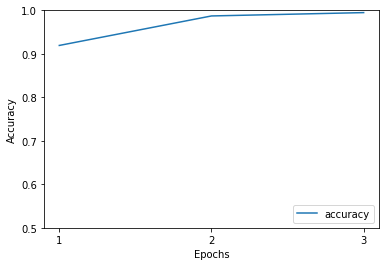

In [ ]:
#Accuracy plot
plt.plot(history.history["accuracy"][0:best_ep], label='accuracy')       
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.xticks(np.arange(len(history.history["accuracy"][0:best_ep])), np.arange(1, len(history.history["accuracy"][0:best_ep])+1))
plt.legend(loc = 'lower right')

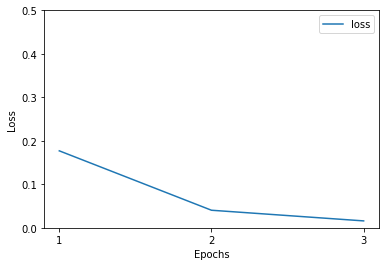

In [ ]:
#Loss plot
plt.plot(history.history["loss"][0:best_ep], label='loss')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.5])
plt.xticks(np.arange(len(history.history["loss"][0:best_ep])), np.arange(1, len(history.history["loss"][0:best_ep])+1))
plt.legend(loc = 'upper right')

# Best Model Performance on Test Set


## Classification Threshold 0.50

In [ ]:
pred = (best_model.predict(padded_test) > 0.5)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9755    0.9874    0.9814      1979
           1     0.9877    0.9762    0.9819      2056

    accuracy                         0.9817      4035
   macro avg     0.9816    0.9818    0.9817      4035
weighted avg     0.9817    0.9817    0.9817      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.17 %


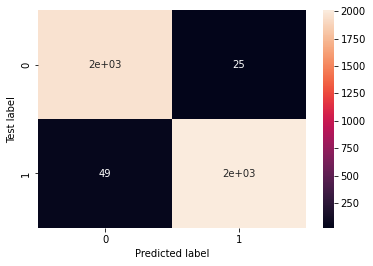

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting The Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

# Best Model Performance on Test Set with different Classification Thresholds

## Classification Threshold 0.80

In [ ]:
pred = (best_model.predict(padded_test) > 0.8)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9717    0.9894    0.9805      1979
           1     0.9896    0.9723    0.9809      2056

    accuracy                         0.9807      4035
   macro avg     0.9807    0.9808    0.9807      4035
weighted avg     0.9808    0.9807    0.9807      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.07 %


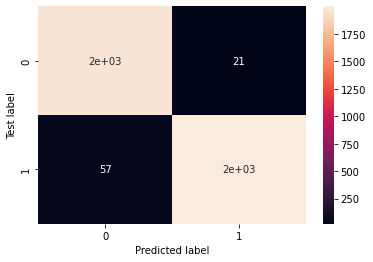

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.90

In [ ]:
pred = (best_model.predict(padded_test) > 0.9)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9699    0.9924    0.9810      1979
           1     0.9925    0.9703    0.9813      2056

    accuracy                         0.9812      4035
   macro avg     0.9812    0.9814    0.9812      4035
weighted avg     0.9814    0.9812    0.9812      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.12 %


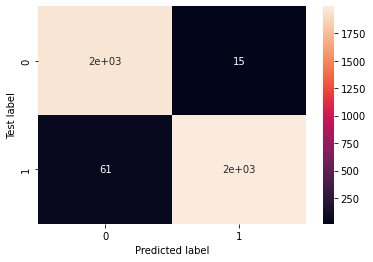

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.95

In [ ]:
pred = (best_model.predict(padded_test) > 0.95)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9671    0.9944    0.9806      1979
           1     0.9945    0.9674    0.9808      2056

    accuracy                         0.9807      4035
   macro avg     0.9808    0.9809    0.9807      4035
weighted avg     0.9810    0.9807    0.9807      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.07 %


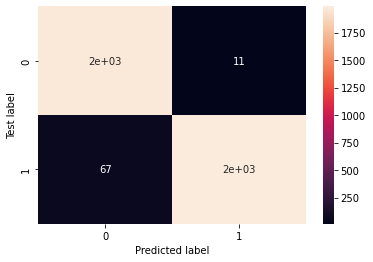

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.99

In [ ]:
pred = (best_model.predict(padded_test) > 0.99)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9960    0.9765      1979
           1     0.9960    0.9577    0.9764      2056

    accuracy                         0.9765      4035
   macro avg     0.9768    0.9768    0.9765      4035
weighted avg     0.9772    0.9765    0.9765      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.65 %


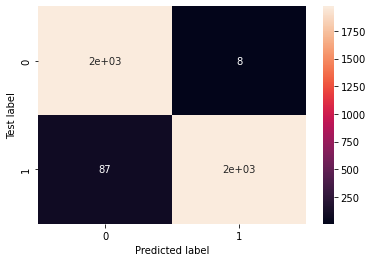

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()